# Chapter 5: Fitting models to data

In [1]:
import pandas as pd
import sidetable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import interp1d
import geopandas

import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import localconverter
# import NHANES package
base = importr('NHANES')

with localconverter(ro.default_converter + pandas2ri.converter):
  NHANES = ro.conversion.rpy2py(ro.r['NHANES'])

 
NHANES = NHANES.drop_duplicates(subset='ID')
NHANES['isChild'] = NHANES.Age < 18
NHANES_adult = NHANES.dropna(subset=['Height']).query('Age > 17')
NHANES_child = NHANES.dropna(subset=['Height']).query('Age < 18')

rng = np.random.RandomState(12345)


## Figure 5.1

<Axes: xlabel='Height', ylabel='Count'>

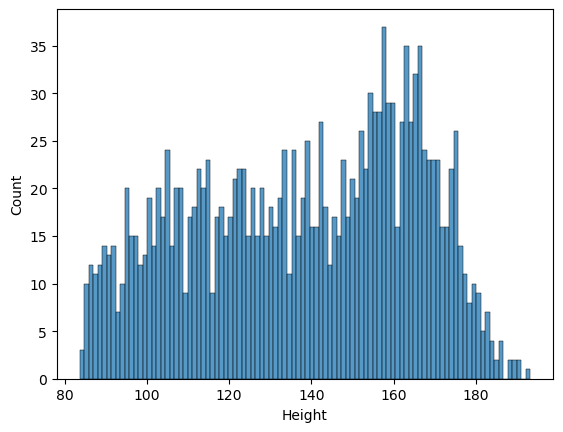

In [2]:
sns.histplot(NHANES_child.Height, bins=100)

## Figure 5.2

Text(0.5, 0, 'Error when predicting height with mean')

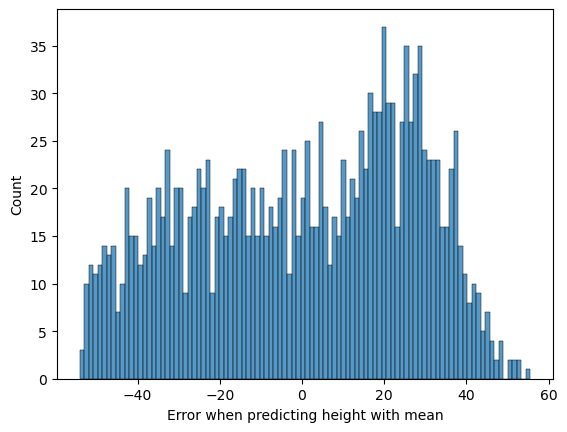

In [3]:
error_mean = NHANES_child.Height - NHANES_child.Height.mean()
error_mode = NHANES_child.Height - NHANES_child.Height.mode().values[0]

sns.histplot(error_mean, bins=100)
plt.xlabel('Error when predicting height with mean')

## Figure 5.3

/opt/conda/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/tmp/ipykernel_698/1526773379.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lr.fit(data.Age[:, np.newaxis], data.Height)
/tmp/ipykernel_698/1526773379.py:34: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lr.fit(data.Age[:, np.newaxis], data.Height)


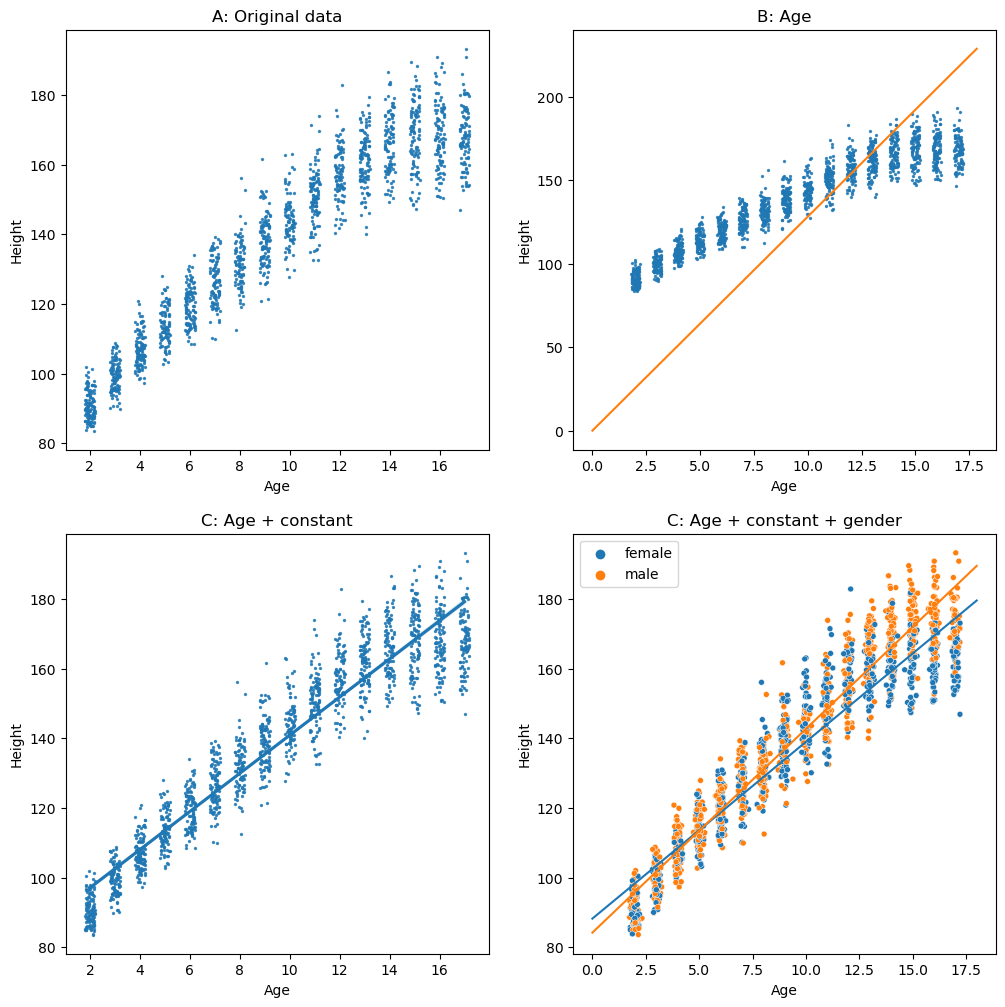

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

NHANES_child['Age_jittered'] = NHANES_child.Age + rng.randn(NHANES_child.shape[0]) * 0.1

sns.regplot(data=NHANES_child, x='Age', y='Height', ax=ax[0][0], 
            x_jitter=0.2, scatter_kws={'s':2}, fit_reg=False)
ax[0][0].set_title('A: Original data')

X = NHANES_child.Age.values[:, np.newaxis]
Y = NHANES_child.Height.values[:, np.newaxis]

slope = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
sns.regplot(data=NHANES_child, x='Age', y='Height', ax=ax[0][1], 
            x_jitter=0.2, scatter_kws={'s':2}, fit_reg=False)
ax[0][1].set_title('B: Age')
ax[0][1].plot([0, NHANES_child.Age.max()*1.05], [0, NHANES_child.Age.max()*1.05*slope])

sns.regplot(data=NHANES_child, x='Age', y='Height', ax=ax[1][0], 
            x_jitter=0.2, scatter_kws={'s':2}, fit_reg=True)
ax[1][0].set_title('C: Age + constant')

sns.scatterplot(data=NHANES_child, x='Age_jittered', y='Height',  hue='Gender', 
                size=2, ax=ax[1][1])
ax[1][1].set_title('C: Age + constant + gender')
h,l = ax[1][1].get_legend_handles_labels()
ax[1][1].legend(h[0:2],l[0:2])

lr = LinearRegression()
xmin = 0
xmax = 18

for gender in ['female', 'male']:
    data = NHANES_child.query(f'Gender == "{gender}"')
    lr.fit(data.Age[:, np.newaxis], data.Height)
    ax[1][1].plot([xmin, xmax], [xmin * lr.coef_[0] + lr.intercept_, xmax * lr.coef_[0] + lr.intercept_, ])
    
for i in range(2):
    for j in range(2):
        ax[i][j].set_ylabel('Height')
        ax[i][j].set_xlabel('Age')


## Figure 5.4

<Axes: xlabel='RMSE', ylabel='model'>

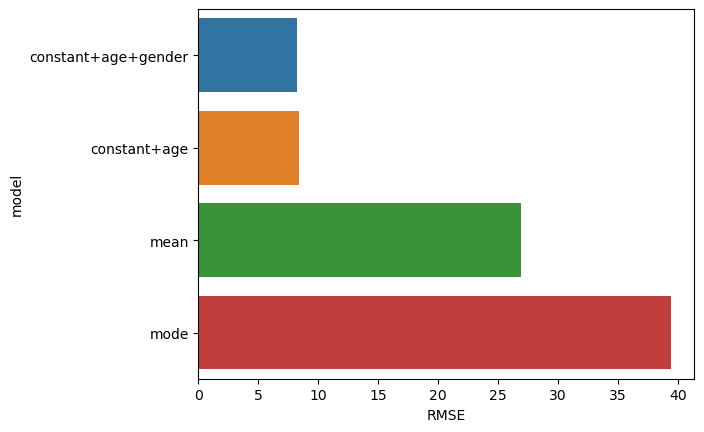

In [5]:
rmse = [['mode', np.sqrt(np.mean(error_mode ** 2))],
        ['mean', np.sqrt(np.mean(error_mean ** 2))]]

lr = LinearRegression()
lr.fit(NHANES_child.Age.values[:, np.newaxis], NHANES_child.Height)
pred = lr.predict(NHANES_child.Age.values[:, np.newaxis])
error_age = NHANES_child.Height - pred
rmse.append(['constant+age', np.sqrt(np.mean(error_age ** 2))])

NHANES_child['Gender_num'] = (NHANES_child.Gender == 'female').astype(int)

lr.fit(NHANES_child[['Age', 'Gender_num']].values, NHANES_child.Height)
pred = lr.predict(NHANES_child[['Age', 'Gender_num']].values)
error_age_gender = NHANES_child.Height - pred
rmse.append(['constant+age+gender', np.sqrt(np.mean(error_age_gender ** 2))])

rmse_df = pd.DataFrame(rmse, columns=['model', 'RMSE']).sort_values(by='RMSE')
sns.barplot(data=rmse_df, x='RMSE', y='model')

## Figure 5.5

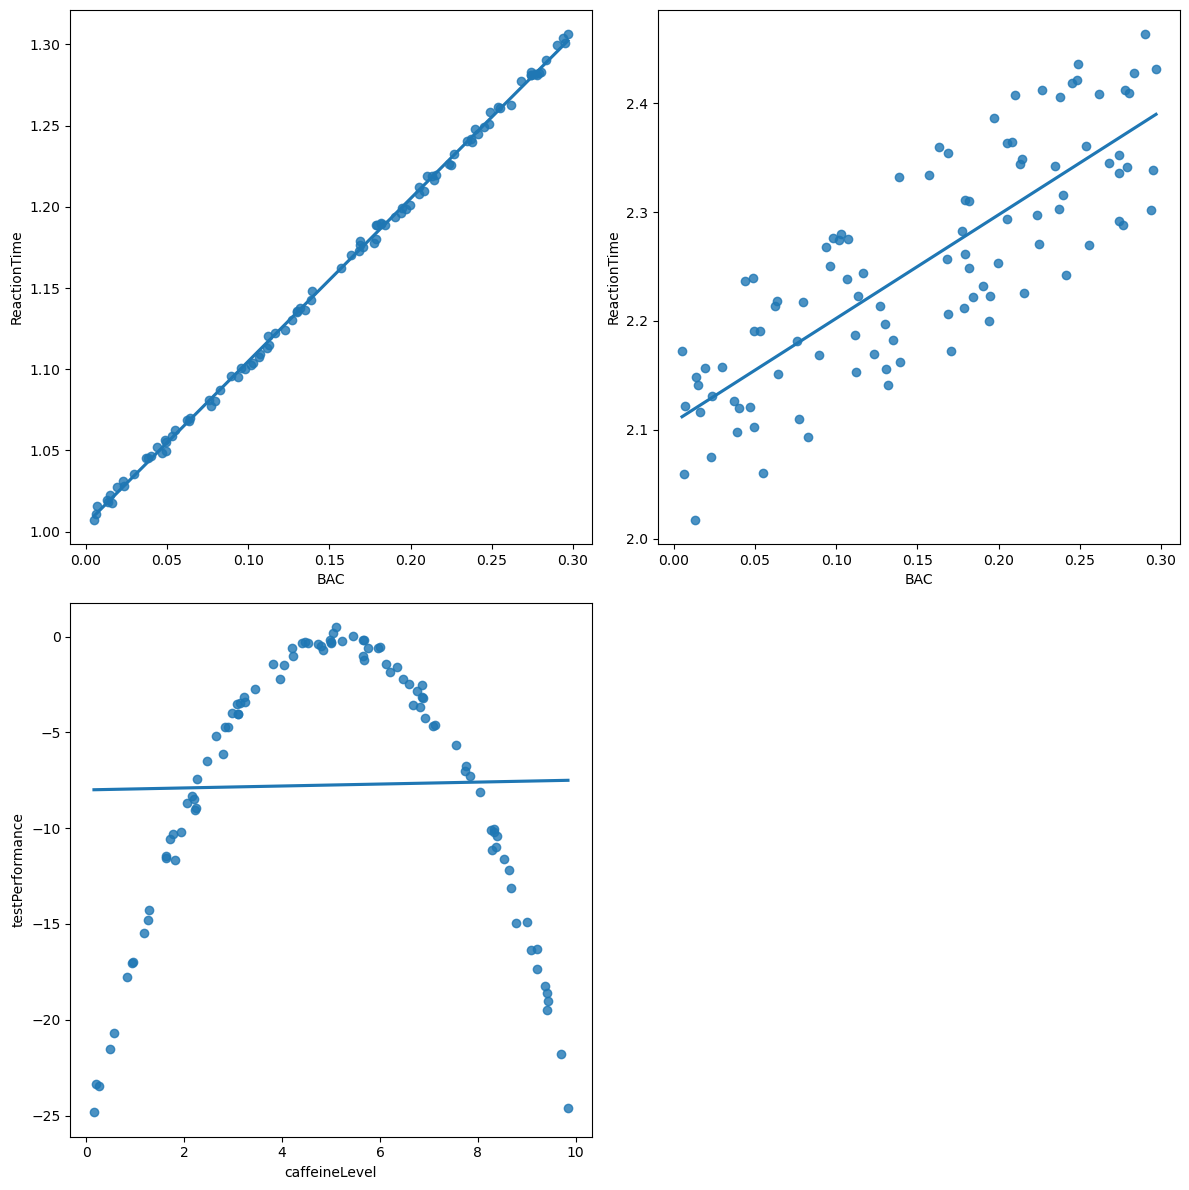

In [6]:
npts = 100
dataDf = pd.DataFrame({'BAC': rng.uniform(size=npts) * 0.3})
dataDf['ReactionTime'] = dataDf.BAC + 1 + rng.random(npts) * .01
dataDf['ReactionTimeNoisy'] = dataDf.BAC + 2 + rng.random(npts) * 0.2

fig, ax = plt.subplots(2, 2, figsize=(12,12))

sns.regplot(data=dataDf, x='BAC', y='ReactionTime', ax=ax[0][0], ci=None)

sns.regplot(data=dataDf, x='BAC', y='ReactionTimeNoisy', ax=ax[0][1], ci=None)
ax[0][1].set_ylabel('ReactionTime')


dataDf = pd.DataFrame({'caffeineLevel': rng.uniform(size=npts) * 10})
dataDf['caffeineLevelInvertedU'] = (dataDf.caffeineLevel - dataDf.caffeineLevel.mean()) ** 2
dataDf['testPerformance'] = -1 * dataDf.caffeineLevelInvertedU + rng.randn(100) * 0.5

sns.regplot(data=dataDf, x='caffeineLevel', y='testPerformance', ax=ax[1][0], ci=None)

ax[1][1].remove()

plt.tight_layout()

## Figure 5.6

Text(0.5, 1.0, 'New data')

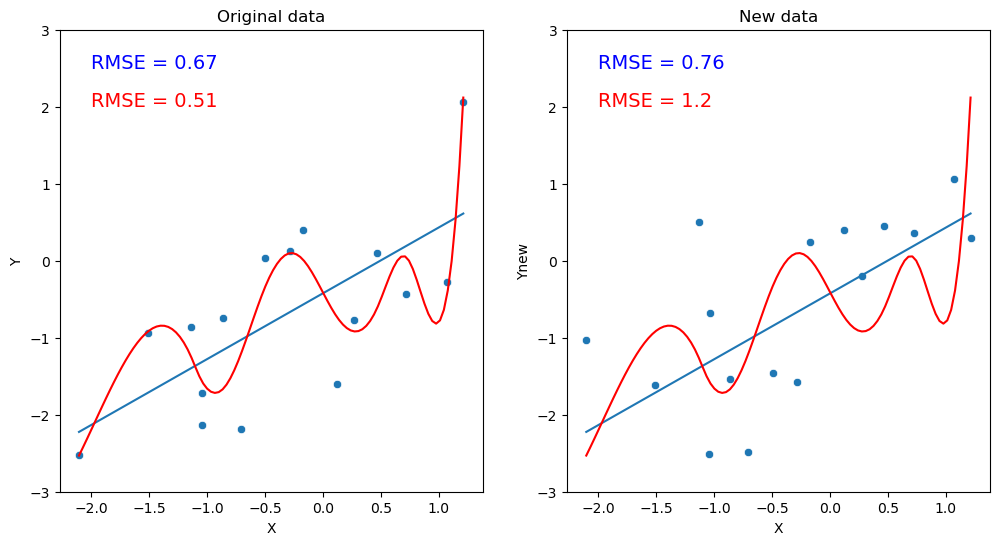

In [7]:
sampleSize = 16
rng = np.random.RandomState(123456)

simData = pd.DataFrame({'X': rng.randn(sampleSize)}).sort_values(by='X')
simData['Y'] = simData['X'] + rng.randn(sampleSize)
simData['Ynew'] = simData['X'] + rng.randn(sampleSize)

Xmin = simData.X.min()
Xmax = simData.X.max()

simpleModel = LinearRegression()
simpleModel.fit(simData.X.values[:, np.newaxis], simData.Y)
simData['simplePred'] = simpleModel.predict(simData.X.values[:, np.newaxis])
simple_rmse = mean_squared_error(simData['simplePred'], simData.Y)
simple_rmse_new = mean_squared_error(simData['simplePred'], simData.Ynew)

complexModel = LinearRegression()
X_complex = PolynomialFeatures(degree=8).fit_transform(simData.X.values[:, np.newaxis])
complexModel.fit(X_complex, simData.Y)
simData['complexPred'] = complexModel.predict(X_complex)
complex_rmse = mean_squared_error(simData['complexPred'], simData.Y, squared=False)
complex_rmse_new = mean_squared_error(simData['complexPred'], simData.Ynew, squared=False)

fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=simData, x='X', y='Y', ax=ax[0])
ax[0].plot(simData.X, simData.simplePred)
f_cubic = interp1d(simData.X, simData.complexPred, kind='cubic')
xnew = np.linspace(Xmin, Xmax, num=100, endpoint=True)
ax[0].plot(xnew, f_cubic(xnew), color='r')
ax[0].set_ylim((-3, 3))
ax[0].annotate(f'RMSE = {simple_rmse:0.2}', xy=[-2, 2.5], color='blue', size=14)
ax[0].annotate(f'RMSE = {complex_rmse:0.2}', xy=[-2, 2], color='red', size=14)
ax[0].set_title('Original data')

sns.scatterplot(data=simData, x='X', y='Ynew', ax=ax[1])
ax[1].plot(simData.X, simData.simplePred)
ax[1].plot(xnew, f_cubic(xnew), color='r')
ax[1].set_ylim((-3, 3))
ax[1].annotate(f'RMSE = {simple_rmse_new:0.2}', xy=[-2, 2.5], color='blue', size=14)
ax[1].annotate(f'RMSE = {complex_rmse_new:0.2}', xy=[-2, 2], color='red', size=14)
ax[1].set_title('New data')

## Figure 5.7

Text(140, 3750000.0, 'mean')

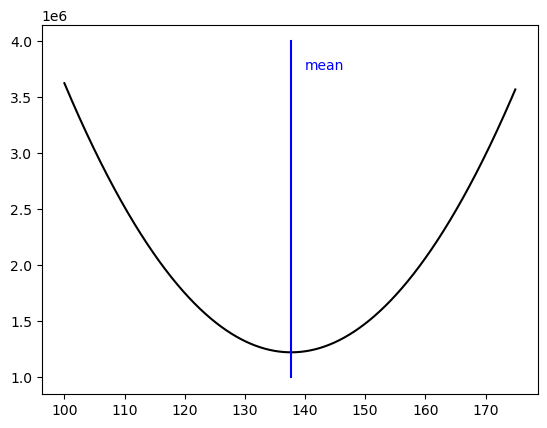

In [8]:
df_error = pd.DataFrame({'val': np.arange(100, 175, 0.05), 'SSE': None})

for i, v in enumerate(df_error.val):
    err = NHANES_child.Height - v
    df_error.loc[i, 'SSE'] = np.sum(err ** 2)
    
plt.plot(df_error.val, df_error.SSE, color='k')
plt.plot([NHANES_child.Height.mean(), NHANES_child.Height.mean()], [1e6, 4e6], color='blue')
plt.annotate('mean', xy=[140, 3.75e6], color='blue')

## Table 5.1

In [9]:
incomeDf = pd.DataFrame({'income': [48000, 64000, 58000, 72000, 66000],
                         'person': ["Joe", "Karen", "Mark", "Andrea", "Pat"]})
incomeDf

,income,person
0,48000,Joe
1,64000,Karen
2,58000,Mark
3,72000,Andrea
4,66000,Pat


## Table 5.2

In [10]:
incomeDf.loc[5, :] = [54000000, "Beyonce"]
incomeDf

,income,person
0,48000.0,Joe
1,64000.0,Karen
2,58000.0,Mark
3,72000.0,Andrea
4,66000.0,Pat
5,54000000.0,Beyonce


## Table 5.3

In [11]:
population_variance = NHANES_child.Height.var(ddof=0)

sampsize = 50
nsamp = 10000

varhat_n = []
varhat_nm1 = []

for i in range(nsamp):
    samp = NHANES_child.sample(sampsize)
    sampmean = samp.Height.mean()
    sse = np.sum((samp.Height - sampmean) ** 2)
    varhat_n.append(sse / sampsize)
    varhat_nm1.append(sse / (sampsize - 1))
    

In [12]:
summary_df = pd.DataFrame(
    {'Estimate': ["Population variance",
                  "Variance estimate using n",
                  "Variance estimate using n-1"],
     'Value': [population_variance,
               np.mean(varhat_n),
               np.mean(varhat_nm1)]})
summary_df

,Estimate,Value
0,Population variance,724.238191
1,Variance estimate using n,712.322398
2,Variance estimate using n-1,726.859590


## Figure 5.8

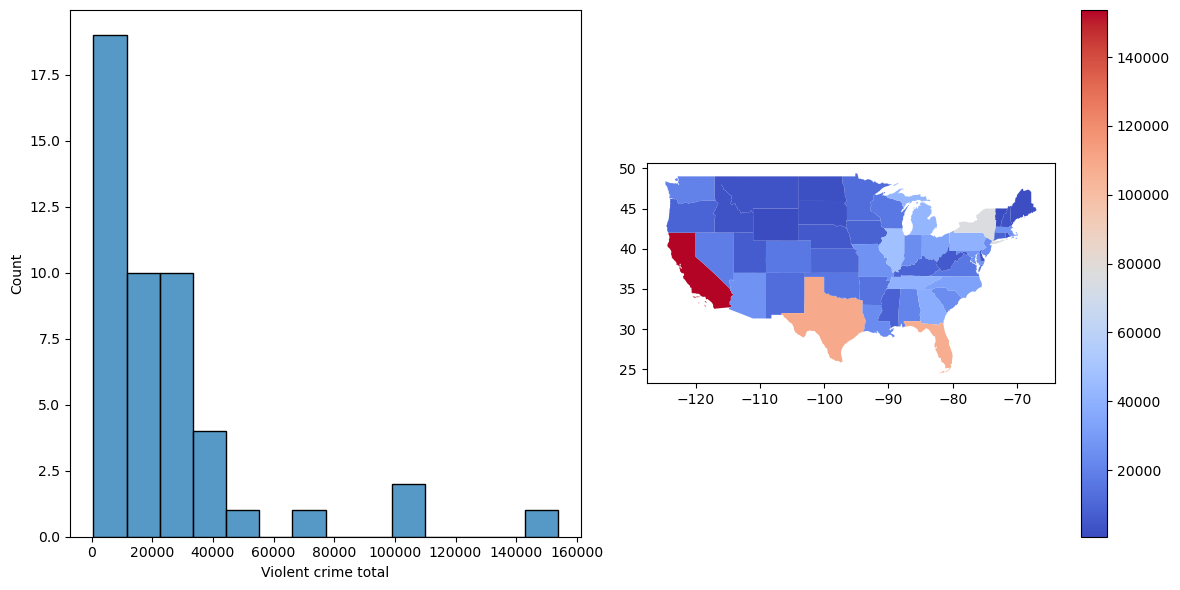

In [13]:

crimeData = pd.read_csv("https://raw.githubusercontent.com/statsthinking21/statsthinking21-figures-data/main//CrimeOneYearofData_clean.csv", index_col=0)

for state in ['District of Columbia', 'Hawaii', 'Alaska']:
    crimeData = crimeData.query(f"State != '{state}'")

caCrimeData = crimeData.query('State == "California"')

fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.histplot(crimeData['Violent crime total'], ax=ax[0])

# based on: https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b

# load the shape file using geopandas
geo_usa = geopandas.read_file('cb_2018_us_state_20m/cb_2018_us_state_20m.shp')

# merge usa_state data and geo_usa shapefile
crimeData['NAME'] = crimeData.State
geo_merge=geo_usa.merge(crimeData,on='NAME')# plot USA map 
geo_merge.plot(column='Violent crime total', 
               figsize=(25, 15),
               legend=True,cmap='coolwarm', ax=ax[1])
plt.tight_layout()

## Figure 5.9

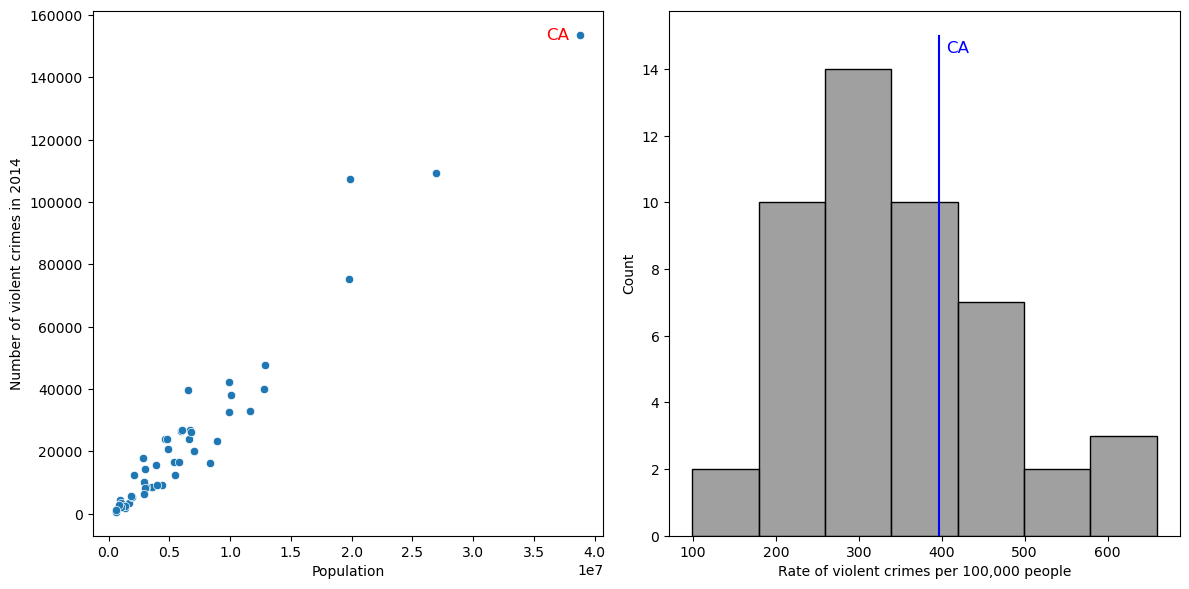

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.scatterplot(data=crimeData, x='Population', y='Violent crime total', 
                ax=ax[0])
ax[0].annotate('CA', [3.6e7, 152000], color='red', size=12)
ax[0].set_ylabel("Number of violent crimes in 2014")

sns.histplot(crimeData['Violent Crime rate'], binwidth=80, color='gray', ax=ax[1])
plt.plot([caCrimeData['Violent Crime rate'].values[0], caCrimeData['Violent Crime rate'].values[0]],
         [0, 15], color='blue')
ax[1].set_xlabel("Rate of violent crimes per 100,000 people")
ax[1].annotate('CA', [405, 14.5], color='blue', size=12)
plt.tight_layout()


## Figure 5.10

<Axes: xlabel='Violent Crime rate', ylabel='ViolentCrimeRateZscore'>

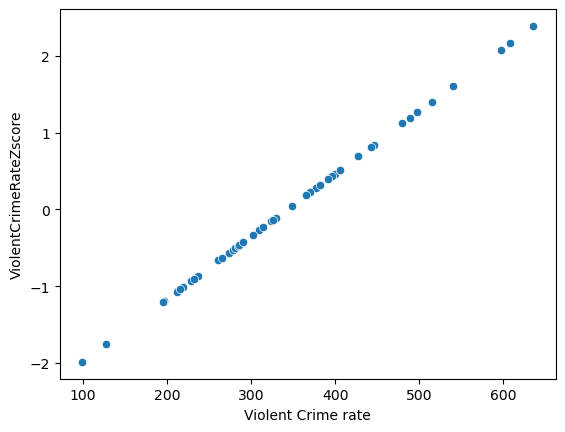

In [15]:
from sklearn.preprocessing import scale

crimeData['ViolentCrimeRateZscore'] = scale(crimeData['Violent Crime rate'])
sns.scatterplot(data=crimeData, x='Violent Crime rate', y='ViolentCrimeRateZscore')

## Figure 5.11

(-127.6146362, -64.0610978, 23.253819649999997, 50.628669349999996)

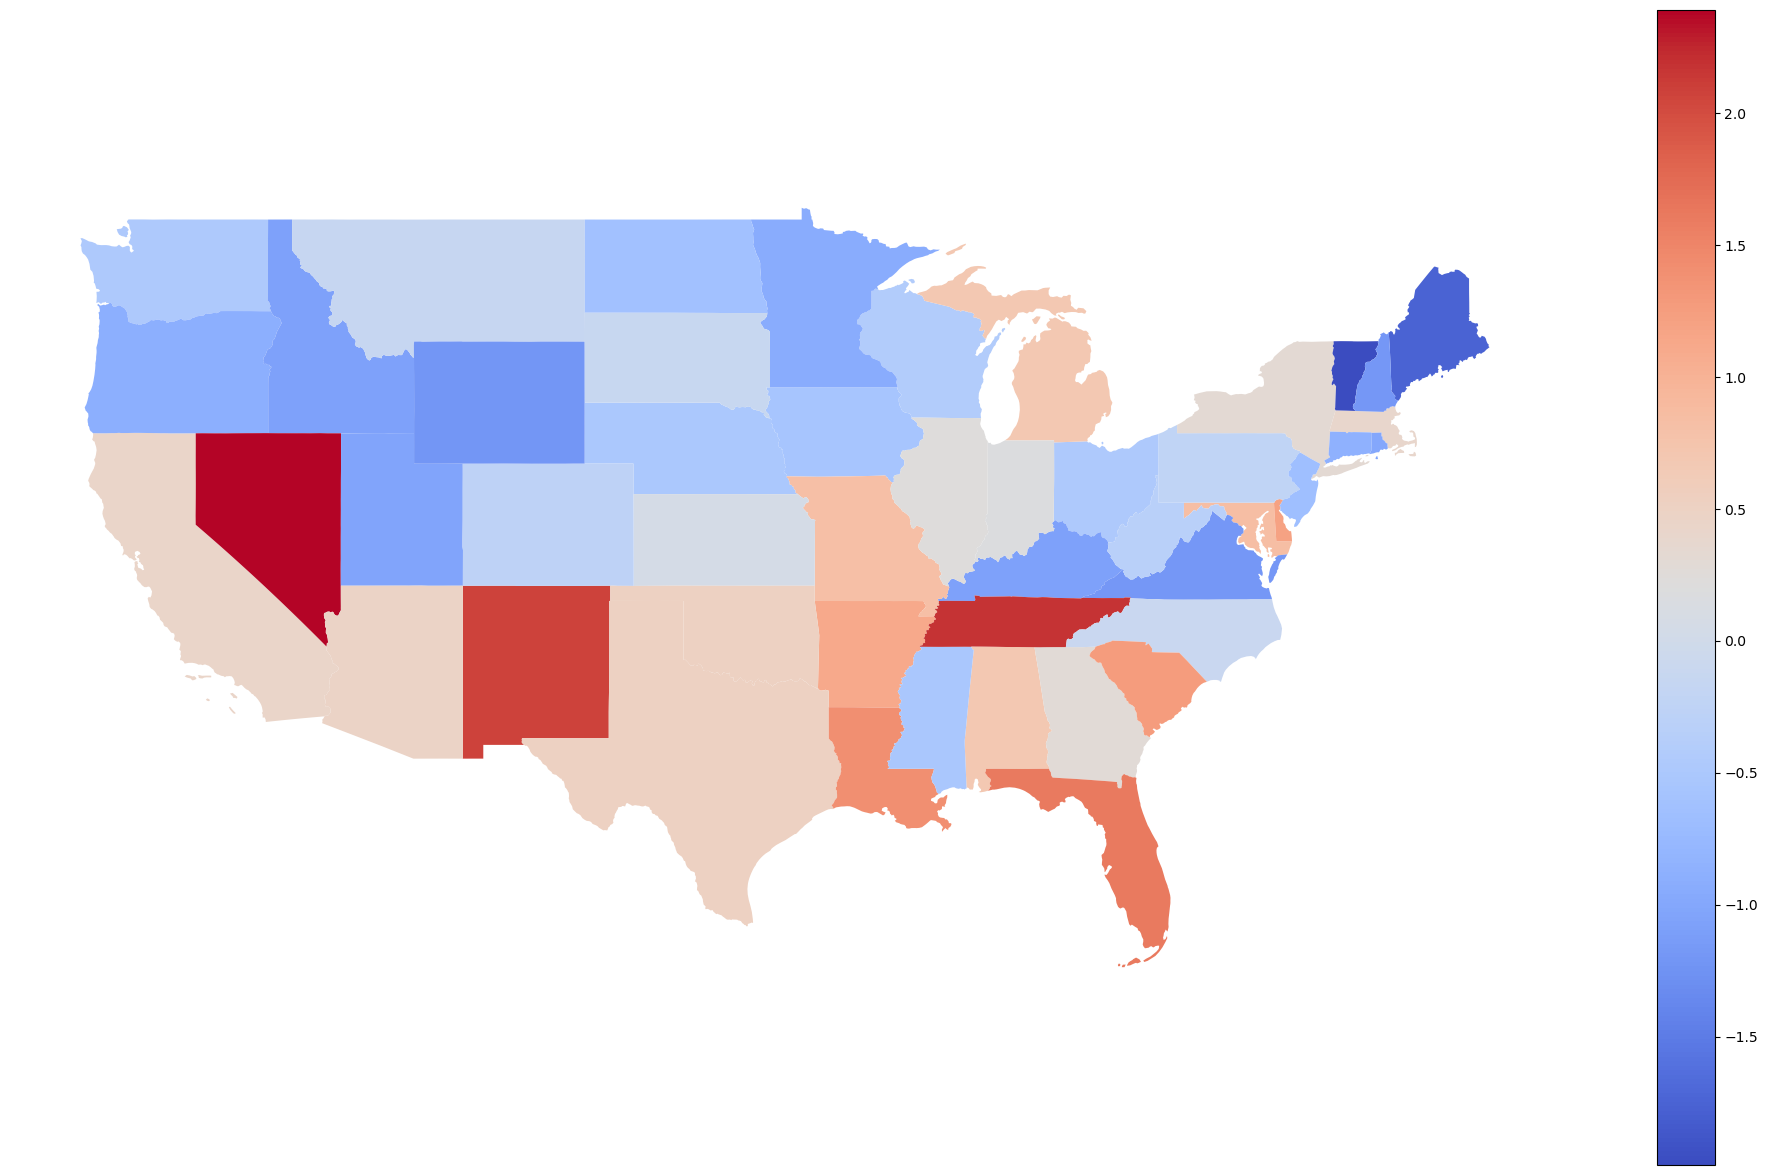

In [16]:
# merge usa_state data and geo_usa shapefile
geo_merge=geo_usa.merge(crimeData,on='NAME')# plot USA map 
geo_merge.plot(column='ViolentCrimeRateZscore', 
               figsize=(25, 15),
               legend=True,cmap='coolwarm')
plt.axis('off')

## Figure 5.12

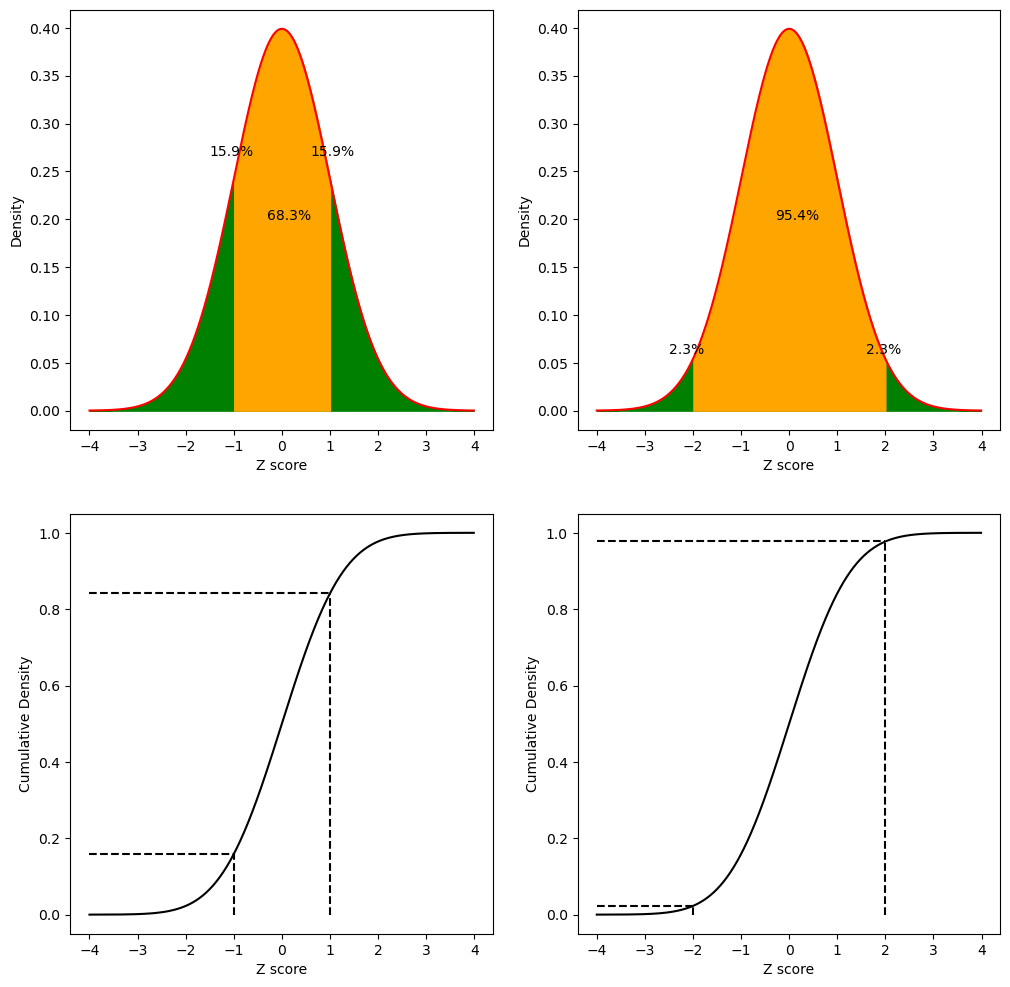

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))


def plot_zscore(sd, ax, zmean=0, zsd=1, zmin=-4, zmax=4):
    dist_df = pd.DataFrame({'Z score': np.arange(zmin, zmax, .01)})
    dist_df['density'] = norm.pdf(dist_df['Z score'].values, loc=zmean, scale=zsd)
    area = (norm.cdf(sd) - norm.cdf(-sd)) * 100
    tail_area = (100 - area) / 2
    
    ax.plot(dist_df['Z score'], dist_df.density, color='red')
    ax.fill_between(x=dist_df['Z score'], y1=dist_df.density, color='green')
    ax.fill_between(x=dist_df['Z score'], y1=dist_df.density, color='orange',
                         where=np.logical_and(dist_df['Z score'].values > -sd, dist_df['Z score'].values < sd))
    ax.annotate(f'{area:.1f}%', [zmean - 0.3, 0.5 * norm.pdf(zmean, loc=zmean, scale=zsd)])
    ax.annotate(f'{tail_area:.1f}%', [-sd - .5, 1.1 * norm.pdf(-sd, loc=zmean, scale=zsd)])
    ax.annotate(f'{tail_area:.1f}%', [sd - .4, 1.1 * norm.pdf(sd, loc=zmean, scale=zsd)])
    ax.set_xlabel('Z score')
    ax.set_ylabel('Density')

plot_zscore(1, ax[0][0])
plot_zscore(2, ax[0][1])

def plot_cdf(sd, ax, zmean=0, zsd=1, zmin=-4, zmax=4):
    dist_df = pd.DataFrame({'Z score': np.arange(zmin, zmax, .01)})
    dist_df['cdf'] = norm.cdf(dist_df['Z score'].values, loc=zmean, scale=zsd)
    ax.plot(dist_df['Z score'], dist_df.cdf, color='black')
    ax.plot([zmin, -sd], [norm.cdf(-sd, loc=zmean, scale=zsd), norm.cdf(-sd, loc=zmean, scale=zsd)], 
            color='k', linestyle='dashed')
    ax.plot([-sd, -sd], [0, norm.cdf(-sd, loc=zmean, scale=zsd)], 
            color='k', linestyle='dashed')
    ax.plot([zmin, sd], [norm.cdf(sd, loc=zmean, scale=zsd), norm.cdf(sd, loc=zmean, scale=zsd)], 
            color='k', linestyle='dashed')
    ax.plot([sd, sd], [0, norm.cdf(sd, loc=zmean, scale=zsd)], 
            color='k', linestyle='dashed')
    ax.set_xlabel('Z score')
    ax.set_ylabel('Cumulative Density')
  
plot_cdf(1, ax[1][0])
plot_cdf(2, ax[1][1])

## Figure 5.13

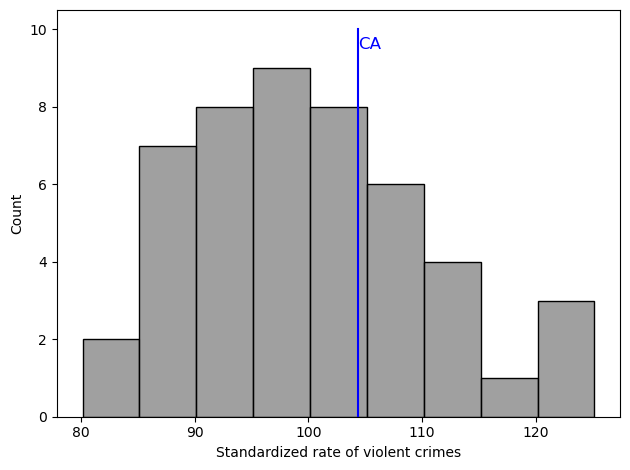

In [18]:
crimeData['ViolentCrimeRateStdScore'] = crimeData.ViolentCrimeRateZscore * 10 + 100

caCrimeData = crimeData.query('State == "California"')

sns.histplot(crimeData['ViolentCrimeRateStdScore'], binwidth=5, color='gray')
plt.plot([caCrimeData['ViolentCrimeRateStdScore'].values[0], caCrimeData['ViolentCrimeRateStdScore'].values[0]],
         [0, 10], color='blue')
plt.xlabel("Standardized rate of violent crimes")
plt.annotate('CA', [104.364111, 9.5], color='blue', size=12)
plt.tight_layout()

## Figure 5.14

Text(0, 0.5, 'Z-scored rate of property crimes')

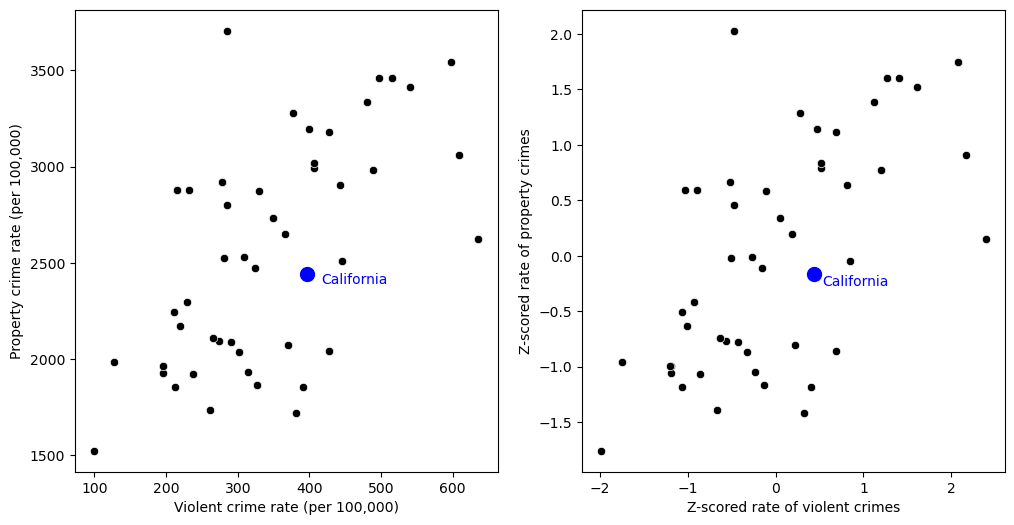

In [19]:
crimeData['PropertyCrimeRateZscore'] = scale(crimeData['Property crime rate'])
caCrimeData = crimeData.query('State == "California"')

fig, ax = plt.subplots(1, 2, figsize=(12,6))

sns.scatterplot(data=crimeData, x='Violent Crime rate', y='Property crime rate', ax=ax[0], color='black')
ax[0].scatter([caCrimeData['Violent Crime rate']], [caCrimeData['Property crime rate']], 
                 color='blue', s=100)
ax[0].annotate('California', [caCrimeData['Violent Crime rate'] + 20, 
                                 caCrimeData['Property crime rate'] - 50], color='blue')
ax[0].set_xlabel('Violent crime rate (per 100,000)')
ax[0].set_ylabel('Property crime rate (per 100,000)')


sns.scatterplot(data=crimeData, x='ViolentCrimeRateZscore', y='PropertyCrimeRateZscore', ax=ax[1], color='black')
ax[1].scatter([caCrimeData['ViolentCrimeRateZscore']], [caCrimeData['PropertyCrimeRateZscore']], 
                 color='blue', s=100)
ax[1].annotate('California', [caCrimeData['ViolentCrimeRateZscore'] + .1, 
                                 caCrimeData['PropertyCrimeRateZscore'] - .1], color='blue')
ax[1].set_xlabel('Z-scored rate of violent crimes')
ax[1].set_ylabel('Z-scored rate of property crimes')


## Figure 5.15

<Axes: xlabel='Population', ylabel='Violence Difference'>

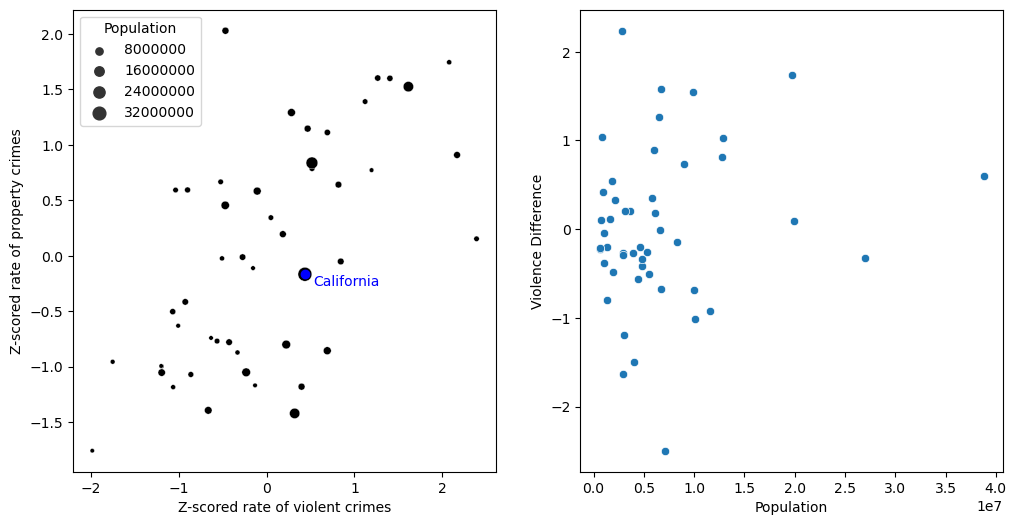

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

crimeData['Violence Difference'] =  crimeData.ViolentCrimeRateZscore - crimeData.PropertyCrimeRateZscore

sns.scatterplot(data=crimeData, x='ViolentCrimeRateZscore', y='PropertyCrimeRateZscore', 
                ax=ax[0], color='black', size=crimeData.Population, sizes=(10, 100))
ax[0].scatter([caCrimeData['ViolentCrimeRateZscore']], [caCrimeData['PropertyCrimeRateZscore']], 
                 color='blue')
ax[0].annotate('California', [caCrimeData['ViolentCrimeRateZscore'] + .1, 
                                 caCrimeData['PropertyCrimeRateZscore'] - .1], color='blue')
ax[0].set_xlabel('Z-scored rate of violent crimes')
ax[0].set_ylabel('Z-scored rate of property crimes')

sns.scatterplot(data=crimeData, x='Population', y='Violence Difference', ax=ax[1])
